## N is a number of unit cells here!

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy as sp
from datetime import datetime
import math

In [2]:
def SSH_hamiltonian_periodic(N1, Delta):
    N = N1*2
    x = np.zeros(N-1)
    x[0::2] = 1 - Delta
    x[1::2] = 1 + Delta
    A = np.diag(x, k = 1) + np.diag(x, k = -1)
    A[0][N-1] = 1 + Delta
    A[N-1][0] = 1 + Delta
    return A

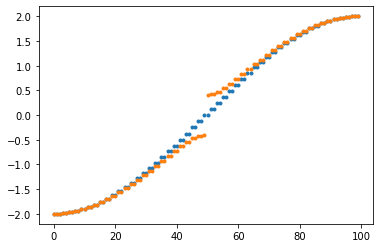

In [3]:
A_SSH = SSH_hamiltonian_periodic(50, 0)
A_SSH1 = SSH_hamiltonian_periodic(50, 0.2)
plt.plot(np.sort(np.linalg.eigvals(A_SSH)), ".")
plt.plot(np.sort(np.linalg.eigvals(A_SSH1)), ".")

In [4]:
def corr_matrix(N1, Delta):
    eps = 1e-15
    eigenvalues, eigenvectors = np.linalg.eigh(SSH_hamiltonian_periodic(N1, Delta))
    idx = eigenvalues.argsort()[::1]   
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:,idx]
    N = N1*2
    Corr_matrix = np.zeros((N,N), dtype = "complex")    
    for i in range(N):
        for j in range(N):
            for k in range(N//2):
                Corr_matrix[i][j] += np.conjugate(eigenvectors[:,k][i])*(eigenvectors[:,k][j])
    return Corr_matrix  

In [5]:
Numer = 2
Delta1 = 0.5
corr_matrix(Numer, Delta1)[Numer:Numer*2, 0:Numer]

array([[ 1.11022302e-16+0.j, -5.00000000e-01+0.j],
       [-5.00000000e-01+0.j,  0.00000000e+00+0.j]])

In [7]:
def corr_matrix_A(N1, Delta, NA):
    eps = 1e-15
    eigenvalues, eigenvectors = np.linalg.eigh(SSH_hamiltonian_periodic(N1, Delta))
    idx = eigenvalues.argsort()[::1]   
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:,idx]
    N = N1*2
    Num = NA*2
    Corr_matrix = np.zeros((Num,Num), dtype = "complex")    
    for i in range(Num):
        for j in range(Num):
            for k in range(N//2):
                Corr_matrix[i][j] += np.conjugate(eigenvectors[:,k][i])*(eigenvectors[:,k][j])
    return Corr_matrix 

In [8]:
def entang_entropy_A(N, Delta, NA):
    CM = corr_matrix_A(N, Delta, NA)
    S = 0.0
    lambd = np.linalg.eigvalsh(CM)
    for i in range(np.shape(CM)[0]):
        if lambd[i] > 1e-14 and (1 - lambd[i]) > 1e-14:     
            S -= lambd[i]*np.log(lambd[i]) + (1 - lambd[i])*np.log(1 - lambd[i])
        else:
            S -= 0
    return S

In [9]:
def entang_entropy_A1(N, Delta, NA):
    CM = corr_matrix_A(N, Delta, NA)
    S = 0.0
    lambd = np.linalg.eigvalsh(CM)
    for i in range(np.shape(CM)[0]):  
        S -= lambd[i]*np.log(lambd[i]) + (1 - lambd[i])*np.log(1 - lambd[i])
    return(S)

Duration: 0:00:04.005127


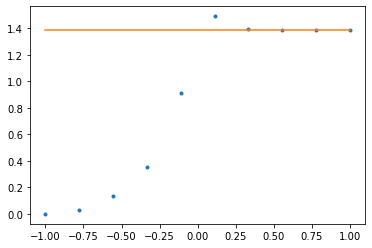

In [10]:
M = 10
N = 50
NA = N//2 
start_time = datetime.now()

Delta = np.linspace(-1,1,M)
Entropy_array = np.array([entang_entropy_A(N, Delta[i], NA) for i in range(M)])
plt.plot(Delta, Entropy_array, ".")
plt.plot(Delta, np.ones(Delta.size)*2*np.log(2))

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

# FOURIER Transform

In [11]:
def u_func(k, Delta, N):
    lambda1 = (1 - Delta) + (1 + Delta)*np.exp(-(2*np.pi/N)*1j*k)
    s = np.sqrt(lambda1 / np.conjugate(lambda1))
    u1 = -(1/np.sqrt(2))*np.array([-1, s]) 
    u2 = -(1/np.sqrt(2))*np.array([1, s])
    return u1, u2 

Почему u_func не работает? Надо пересчитать! Что там с блоховскими состояниями?

In [12]:
def u_func_new(k, Delta, N):
    H = np.array([[0, (1 - Delta) + (1 + Delta)*np.exp(-(2*np.pi/N)*1j*k)],[(1 - Delta) + (1 + Delta)*np.exp((2*np.pi/N)*1j*k), 0]])
    eigenvalues, eigenvectors = np.linalg.eigh(H)
    idx = eigenvalues.argsort()[::1]   
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:,idx]
    return eigenvectors

In [13]:
u_func_new(2, 0, 6)

array([[-0.70710678-0.j        , -0.70710678+0.j        ],
       [ 0.35355339+0.61237244j, -0.35355339-0.61237244j]])

In [14]:
def corr_matrix_new(N1, Delta):
    N = N1*2
    eps = 1e-15
    C = np.zeros((N,N),dtype = "complex")
    for i in range(N):
        for j in range(N):
            for k in range(N//2):
                    C[i][j] += (1/N1)*np.conjugate(u_func_new(k, Delta, N1)[:,0][i%2])*np.exp(-(2*np.pi/N1)*1j*k*(i//2 - j//2))*u_func_new(k, Delta, N1)[:,0][j%2]
    return C

In [15]:
C = corr_matrix_A(10, 0.05, 5)
eigenvalues = np.linalg.eigvalsh(C)
idx = eigenvalues.argsort()[::1]   
eigenvalues = eigenvalues[idx]
print(eigenvalues)
print(eigenvalues[-3-1] + eigenvalues[3])

[2.29795828e-07 2.29795828e-07 3.21659367e-03 3.21659367e-03
 5.00000000e-01 5.00000000e-01 9.96783406e-01 9.96783406e-01
 9.99999770e-01 9.99999770e-01]
0.9999999999999986


In [16]:
def corr_matrix_A_new(N1, Delta, NA):
    N = N1*2
    Num = NA*2
    eps = 1e-15
    C = np.zeros((Num,Num),dtype = "complex")
    for i in range(Num):
        for j in range(Num):
            for k in range(N//2):
                    C[i][j] += (1/N1)*np.conjugate(u_func_new(k, Delta, N1)[:,0][i%2])*np.exp(-(2*np.pi/N1)*1j*k*(i//2 - j//2))*u_func_new(k, Delta, N1)[:,0][j%2]
    return C

In [17]:
def entang_entropy_A_new(N, Delta, NA):
    CM = corr_matrix_A_new(N, Delta, NA)
    S = 0.0
    lambd = np.linalg.eigvalsh(CM)
    for i in range(np.shape(CM)[0]):
        if lambd[i] > 1e-14 and (1 - lambd[i]) > 1e-14:     
            S -= lambd[i]*np.log(lambd[i]) + (1 - lambd[i])*np.log(1 - lambd[i])
        else:
            S -= 0
    return(S)

Duration: 0:00:00.866809


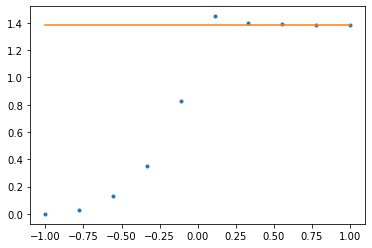

In [18]:
M = 10
N = 10
NA = N//2
start_time = datetime.now()

Delta = np.linspace(-1,1,M)
Entropy_array_new = np.array([entang_entropy_A_new(N, Delta[i], NA) for i in range(M)])
plt.plot(Delta, Entropy_array_new, ".")
plt.plot(Delta, np.ones(Delta.size)*2*np.log(2))

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

In [19]:
#symmetry of the correlation matrix A

Num = 50

Delta = 0.9
S = corr_matrix_A(Num, Delta, Num//2)
S_eigvals = np.linalg.eigvalsh(S)
S_new = []
for i in range(Num//2):
    S_new.append(S_eigvals[i] + S_eigvals[-i-1])
S_new = np.array(S_new)
print("S old = ", S_eigvals)
print("S new = ", S_new)

S old =  [-5.23391544e-16 -4.97914811e-16 -3.70224246e-16 -3.51218758e-16
 -3.01493660e-16 -2.38743418e-16 -1.97888462e-16 -1.53922413e-16
 -1.03857259e-16 -9.75506218e-17 -6.43654685e-17 -1.74359356e-18
  2.53029130e-17  6.79349035e-17  1.06274189e-16  1.19095519e-16
  1.79403206e-16  2.83508849e-16  2.92488284e-16  3.45218662e-16
  6.93887087e-16  8.16081279e-16  3.00573026e-08  3.00573028e-08
  5.00000000e-01  5.00000000e-01  9.99999970e-01  9.99999970e-01
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00]
S new =  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]


In [20]:
def Z_n(n, alpha, eigenvalues, N1):
    Z = 1.0
    alpha = alpha*(2*np.pi/(N1+1))
    Ns = eigenvalues.size
    for m in range(Ns):
        lam = eigenvalues[m]
        Z *= ((lam**n)*np.exp(1j*alpha*(1 - lam)) + ((1 - lam)**n)*np.exp(-1j*alpha*lam))
    return Z


#real Z_N expression

In [21]:
def eigval_corr_matrix(N1, Delta, NA):
    C = corr_matrix_A(N1, Delta, NA)
    eigenvalues= np.linalg.eigvalsh(C)
    idx = eigenvalues.argsort()[::1]   
    eigenvalues = eigenvalues[idx]
    return eigenvalues

def Z_n_real(n, alpha, eigenvalues, N1):
    Z = 1.0
    Ns = eigenvalues.size 
    alpha = alpha*(2*np.pi/(N1+1)) 
    for m in range(Ns//2):
        lam = eigenvalues[m]
        Z *= (lam**(2*n) + (1 - lam)**(2*n) + 2*(lam**n)*((1 - lam)**n)*np.cos(alpha))
    return Z

'''def Z_n_real(n, alpha, Delta, N1):
    #alpha goes from -pi to pi
    C = corr_matrix_A(N1, Delta)
    eigenvalues= np.linalg.eigvalsh(C)
    idx = eigenvalues.argsort()[::1]   
    eigenvalues = eigenvalues[idx]
    Z = 1.0
    for m in range(N1//2):
        lam = eigenvalues[m]
        Z *= (lam**(2*n) + (1 - lam)**(2*n) + 2*(lam**n)*((1 - lam)**n)*np.cos(alpha))
    return Z'''

'def Z_n_real(n, alpha, Delta, N1):\n    #alpha goes from -pi to pi\n    C = corr_matrix_A(N1, Delta)\n    eigenvalues= np.linalg.eigvalsh(C)\n    idx = eigenvalues.argsort()[::1]   \n    eigenvalues = eigenvalues[idx]\n    Z = 1.0\n    for m in range(N1//2):\n        lam = eigenvalues[m]\n        Z *= (lam**(2*n) + (1 - lam)**(2*n) + 2*(lam**n)*((1 - lam)**n)*np.cos(alpha))\n    return Z'

In [22]:
'''N = 10
alpha_test = np.array([2*np.pi*j/N for j in range(N)])
Delta = 1
typ = 1
Z_n_test = np.array(Z_n(typ, alpha_test[i], Delta, N) for i in range(N))
plt.plot(alpha_test, Z_n_test)'''

'N = 10\nalpha_test = np.array([2*np.pi*j/N for j in range(N)])\nDelta = 1\ntyp = 1\nZ_n_test = np.array(Z_n(typ, alpha_test[i], Delta, N) for i in range(N))\nplt.plot(alpha_test, Z_n_test)'

In [23]:
def log_Z_n(n, alpha, eigenvalues, N1):
    #alpha goes from 0 to 2 pi
    Z = 1.0
    Ns = eigenvalues.size
    alpha = alpha*(2*np.pi/(N1+1)) 
    for m in range(N1):
        lam = eigenvalues[m]
        Z += np.log(((lam**n)*np.exp(1j*alpha*(1 - lam)) + ((1 - lam)**n)*np.exp(-1j*alpha*lam)))
    return Z

In [24]:
def log_Z_n_real(n, alpha, eigenvalues, N1):
    #alpha goes from 0 to 2 pi
    Z = 1.0
    Ns = eigenvalues.size
    alpha = alpha*(2*np.pi/(N1+1)) 
    for m in range(N1//2):
        lam = eigenvalues[m]
        Z += np.log(lam**(2*n) + (1 - lam)**(2*n) + 2*(lam**n)*((1 - lam)**n)*np.cos(alpha))
    return Z

In [25]:
N_cells = 50
N  = N_cells + 1
type_num = 1

Delta_array = np.array([-1, 1,-0.5, 0.5, -0.2, 0.2, -0.1, 0.1, -0.05, 0.05,-0.02, 0.02, -0.01, 0.01, 0])
alpha_array =  np.array([i for i in range(N)])

In [26]:
print(alpha_array) 
#do not count 0 2pi twice FOR ALPHA AND FOR Q

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50]


Duration: 0:00:00.005981


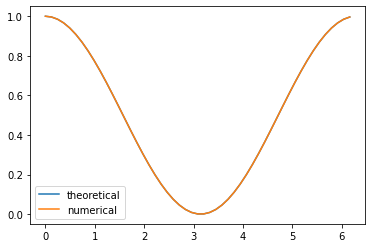

In [27]:
A = eigval_corr_matrix(N_cells, Delta_array[1], N_cells//2)

start_time = datetime.now()

Z_n_array0 = np.array([Z_n_real(type_num, alpha_array[i], A, N_cells) for i in range(N)])

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

plt.plot(alpha_array*(2*np.pi/N), np.cos(alpha_array*(np.pi/N))**2, label = "theoretical")
plt.plot(alpha_array*(2*np.pi/N), Z_n_array0, label = "numerical")
plt.legend()

In [28]:
Corr_matrix_eigvals = []
for i in range(Delta_array.size):
    Corr_matrix_eigvals.append(eigval_corr_matrix(N_cells, Delta_array[i], N_cells//2))

In [29]:
Z_n_array = []
for j in range(Delta_array.size):
    Z_n_array.append(np.array([Z_n_real(type_num, alpha_array[i], Corr_matrix_eigvals[j], N_cells) for i in range(N)]))

Text(0.5, 1.0, '$\\delta$ = 1, N =51')

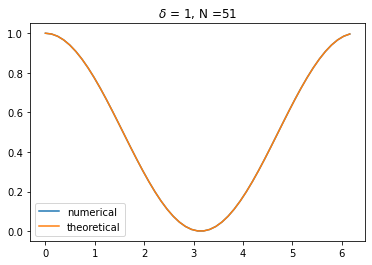

In [30]:
# For delta = 1

plt.plot(alpha_array*(2*np.pi/N), Z_n_array[1], label = "numerical") #numerical result 
plt.plot(alpha_array*(2*np.pi/N), np.cos(alpha_array*(np.pi/N))**2, label = "theoretical") #theoretical result
plt.legend()
plt.title("$\delta$ = 1, N =" + str(N))

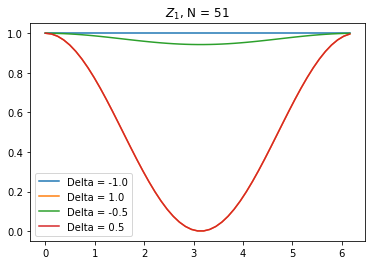

In [31]:
for i in range(4):
    plt.plot(alpha_array*(2*np.pi/N), Z_n_array[i], label = "Delta = " + str(Delta_array[i]))
    plt.legend()
    plt.title("$Z_1$, N = " + str(N))

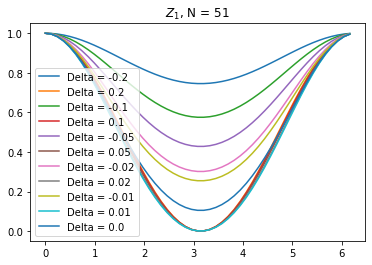

In [32]:
for i in range(4,Delta_array.size):
    plt.plot(alpha_array*(2*np.pi/N), Z_n_array[i], label = "Delta = " + str(Delta_array[i]))
    plt.legend()
    plt.title("$Z_1$, N = " + str(N))

In [33]:
N_cells = 50
N  = N_cells + 1
typ = 2

log_Z_n_array = []
for j in range(Delta_array.size):
    log_Z_n_array.append(np.array([log_Z_n_real(typ, alpha_array[i], Corr_matrix_eigvals[j], N_cells) for i in range(N)]))

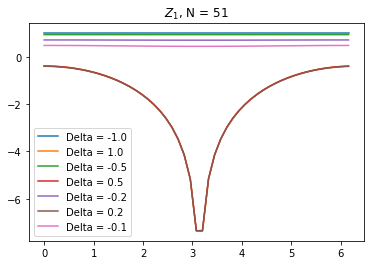

In [34]:
for i in range(Delta_array.size//2):
    plt.plot(alpha_array*(2*np.pi/N), log_Z_n_array[i], label = "Delta = " + str(Delta_array[i]))
    plt.legend()
    plt.title("$Z_1$, N = " + str(N))

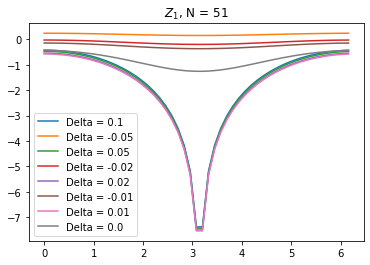

In [35]:
for i in range(Delta_array.size//2,Delta_array.size):
    plt.plot(alpha_array*(2*np.pi/N), log_Z_n_array[i], label = "Delta = " + str(Delta_array[i]))
    plt.legend()
    plt.title("$Z_1$, N = " + str(N))

In [36]:
def DFT(array):
#N should be even, if N is odd, you need to change to np.concatenate((array_k[N//2:N], array_k[0:N//2])
    N = array.size
    array_k = np.zeros(N)
    for k in range(N):
        for i in range(N):
            array_k[k] += (1/np.sqrt(N))*(array[i]*np.cos(2*np.pi*k*i/(N)))
    return np.concatenate((array_k[(N//2+1):N], array_k[0:(N//2+1)]))

In [37]:
'''def DFT_half1(array):
    N = array.size
    array_k = np.zeros(N)
    for k in range(-N//2 + 1,N//2 + 1):
        array_k[k] = array[0]/(np.sqrt(N))
        for i in range(1,N//2 + 1):
            array_k[k] += 2*(1/np.sqrt(N))*(array[i]*np.cos(2*np.pi*k*i/(N)))
    return np.concatenate((array_k[(N//2+1):N], array_k[0:(N//2+1)]))'''

'def DFT_half1(array):\n    N = array.size\n    array_k = np.zeros(N)\n    for k in range(-N//2 + 1,N//2 + 1):\n        array_k[k] = array[0]/(np.sqrt(N))\n        for i in range(1,N//2 + 1):\n            array_k[k] += 2*(1/np.sqrt(N))*(array[i]*np.cos(2*np.pi*k*i/(N)))\n    return np.concatenate((array_k[(N//2+1):N], array_k[0:(N//2+1)]))'

In [38]:
def DFT_half(array_half):
    N = (array_half.size)*2 - 1
    array_k = np.zeros(N)
    for k in range(-N//2 + 1,N//2 + 1):
        array_k[k] = array_half[0]/(np.sqrt(N))
        for i in range(1,N//2 + 1):
            array_k[k] += 2*(1/np.sqrt(N))*(array_half[i]*np.cos(2*np.pi*k*i/(N)))
    return np.concatenate((array_k[(N//2+1):N], array_k[0:(N//2+1)]))

In [39]:
np.allclose(DFT_half(Z_n_array[1][0:(Z_n_array[1].size//2 + 1)]), DFT(Z_n_array[1]))

True

In [40]:
print("half ", DFT_half(Z_n_array[1][0:(N//2 + 1)]))
print("full",  DFT(Z_n_array[1]))

np.allclose(DFT(Z_n_array[1]), DFT_half(Z_n_array[1][0:(N//2 + 1)]))

half  [ 7.20367640e-17  1.35142413e-16 -3.07066384e-16  8.14757604e-16
  6.72422187e-16  7.33462770e-17  1.00287346e-15  5.79641586e-16
  7.33191719e-17 -6.84754987e-16 -9.44069042e-17 -8.46219796e-17
  1.14364356e-15  4.21131229e-16  2.71646854e-16  3.05880538e-16
  1.72008675e-16  1.71222628e-16  2.22532496e-16  4.36499795e-16
  2.19388310e-16 -1.68051337e-17  2.39500260e-16 -3.03956079e-16
  1.78535711e+00  3.57071421e+00  1.78535711e+00 -3.03956079e-16
  2.39500260e-16 -1.68051337e-17  2.19388310e-16  4.36499795e-16
  2.22532496e-16  1.71222628e-16  1.72008675e-16  3.05880538e-16
  2.71646854e-16  4.21131229e-16  1.14364356e-15 -8.46219796e-17
 -9.44069042e-17 -6.84754987e-16  7.33191719e-17  5.79641586e-16
  1.00287346e-15  7.33462770e-17  6.72422187e-16  8.14757604e-16
 -3.07066384e-16  1.35142413e-16  7.20367640e-17]
full [-4.71844785e-16 -4.27435864e-15  4.16333634e-16  6.05071548e-15
  3.78863607e-15 -1.38777878e-17 -7.21644966e-15  2.67841305e-15
 -3.91353616e-15  1.12410081e

True

In [41]:
q_array = np.array([i for i in range(N)])

Text(0.5, 1.0, '$Z_1 (q)$, $N$ = 50')

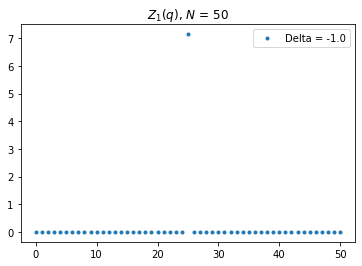

In [42]:
plt.plot(q_array, DFT_half(Z_n_array[0][0:(N//2 + 1)]), ".", label = "Delta = " + str(Delta_array[0]))
plt.legend()
plt.title("$Z_1 (q)$, $N$ = " + str(N_cells))

Z_N_array, delta = 1.0
[1.00000000e+00 9.96210255e-01 9.84898468e-01 9.66236115e-01
 9.40506097e-01 9.08098456e-01 8.69504459e-01 8.25309150e-01
 7.76182486e-01 7.22869178e-01 6.66177400e-01 6.06966542e-01
 5.46134180e-01 4.84602471e-01 4.23304173e-01 3.63168505e-01
 3.05107063e-01 2.50000000e-01 1.98682682e-01 1.51933027e-01
 1.10459713e-01 7.48914321e-02 4.57673641e-02 2.35289998e-02
 8.51345016e-03 9.48335631e-04 9.48335631e-04 8.51345016e-03
 2.35289998e-02 4.57673641e-02 7.48914321e-02 1.10459713e-01
 1.51933027e-01 1.98682682e-01 2.50000000e-01 3.05107063e-01
 3.63168505e-01 4.23304173e-01 4.84602471e-01 5.46134180e-01
 6.06966542e-01 6.66177400e-01 7.22869178e-01 7.76182486e-01
 8.25309150e-01 8.69504459e-01 9.08098456e-01 9.40506097e-01
 9.66236115e-01 9.84898468e-01 9.96210255e-01]


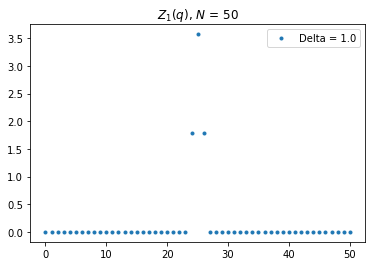

In [43]:
plt.plot(q_array, DFT(Z_n_array[1]), ".", label = "Delta = " + str(Delta_array[1]))
plt.legend()
plt.title("$Z_1 (q)$, $N$ = " + str(N_cells))
print("Z_N_array, delta = " + str(Delta_array[1]), Z_n_array[1], sep = "\n")

In [44]:
def IDFT(array):
    N = array.size
    array = np.concatenate((array[(N//2):N], array[0:(N//2)]))
    array_k = np.zeros(N)
    for k in range(0,N):
        for i in range(0,N):
            array_k[k] += (1/(np.sqrt(N)))*(array[i]*np.cos(2*np.pi*k*i/N))
    return array_k

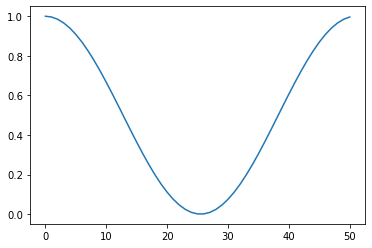

In [46]:
plt.plot(alpha_array, IDFT(DFT_half(Z_n_array[1][0:(N//2+1)])))

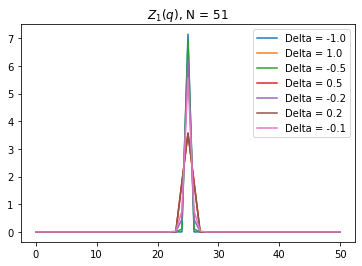

In [47]:
for i in range(Delta_array.size//2):
    plt.plot(q_array, DFT(Z_n_array[i]), label = "Delta = " + str(Delta_array[i]))
    plt.legend()
    plt.title("$Z_1 (q)$, N = " + str(N))

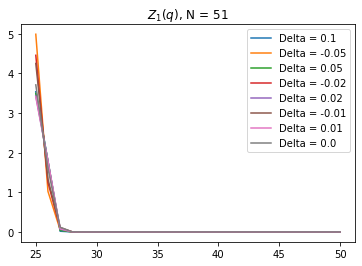

In [48]:
for i in range(Delta_array.size//2, Delta_array.size):
    plt.plot(q_array[q_array.size//2:q_array.size], DFT(Z_n_array[i])[q_array.size//2:q_array.size], label = "Delta = " + str(Delta_array[i]))
    plt.legend()
    plt.title("$Z_1 (q)$, N = " + str(N))
plt.rcParams["figure.figsize"] = (8,5.5)

Text(0.5, 1.0, '$Z_1 (q)$, N = 51')

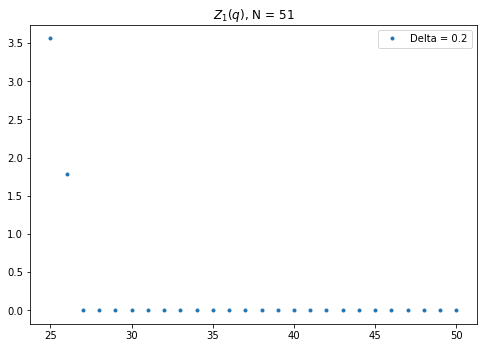

In [49]:
plt.plot(q_array[q_array.size//2:q_array.size], DFT(Z_n_array[5])[q_array.size//2:q_array.size], ".", label = "Delta = " + str(Delta_array[5]))
plt.legend()
plt.title("$Z_1 (q)$, N = " + str(N))

# Logarithm of $Z_1$ (q)

## N dependence

### $\delta$ = 0.01 

In [50]:
print(np.exp(-32))

1.2664165549094176e-14


In [51]:
def critical_length(delta):
    f = 1/np.log((1 + delta)/(1 - delta))
    return [f , math.ceil(f/2.)*2]

In [52]:
critical_length(0.5)

[0.9102392266268373, 2]

In [53]:
N_cells0 = 4
N0  = N_cells0 + 1
type_num = 1

Delta = 0.01
alpha_array0 =  np.array([i for i in range(N0)])

A0 = eigval_corr_matrix(N_cells0, Delta, N_cells0//2)
Z_n_array0 = np.array([Z_n_real(type_num, alpha_array0[i], A0, N_cells0) for i in range(N0//2 + 1)])
q_array0 = np.array([i for i in range(N0)])

In [54]:
N_cells1 = 6
N1  = N_cells1 + 1
type_num = 1

Delta = 0.01
alpha_array1 =  np.array([i for i in range(N1)])

A1 = eigval_corr_matrix(N_cells1, Delta, N_cells1//2)
Z_n_array1 = np.array([Z_n_real(type_num, alpha_array1[i], A1, N_cells1) for i in range(N1//2 + 1)])
q_array1 = np.array([i for i in range(N1)])

In [55]:
N_cells2 = 10
N2  = N_cells2 + 1
type_num = 1

Delta = 0.01
alpha_array2 =  np.array([i for i in range(N2)])

A2 = eigval_corr_matrix(N_cells2, Delta, N_cells2//2)
Z_n_array2 = np.array([Z_n_real(type_num, alpha_array2[i], A2, N_cells2) for i in range(N2//2 + 1)])
q_array2 = np.array([i for i in range(N2)])

In [56]:
N_cells3 = 20
N3  = N_cells3 + 1
type_num = 1

Delta = 0.01
alpha_array3 =  np.array([i for i in range(N3)])

A3 = eigval_corr_matrix(N_cells3, Delta,N_cells3//2)
Z_n_array3 = np.array([Z_n_real(type_num, alpha_array3[i], A3, N_cells3) for i in range(N3//2 + 1)])
q_array3 = np.array([i for i in range(N3)])

In [57]:
N_cells4 = 50
N4  = N_cells4 + 1
type_num = 1

Delta = 0.01
alpha_array4 =  np.array([i for i in range(N4)])

from datetime import datetime
start_time = datetime.now()
A4 = eigval_corr_matrix(N_cells4, Delta,N_cells4//2)

Z_n_array4 = np.array([Z_n_real(type_num, alpha_array4[i], A4, N_cells4) for i in range(N4//2 + 1)])
q_array4 = np.array([i for i in range(N4)])

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:00.442856


In [58]:
N_cells5 = 200
N5  = N_cells5 + 1
type_num = 1

Delta = 0.01
alpha_array5 =  np.array([i for i in range(N5)])

from datetime import datetime
start_time = datetime.now()
A5 = eigval_corr_matrix(N_cells5, Delta, N_cells5//2)

Z_n_array5 = np.array([Z_n_real(type_num, alpha_array5[i], A5, N_cells5) for i in range(N5//2 + 1)])
q_array5 = np.array([i for i in range(N5)])

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:25.601633


In [59]:
N_cells6 = 300
N6  = N_cells6 + 1
type_num = 1

Delta = 0.01
alpha_array6 =  np.array([i for i in range(N6)])

from datetime import datetime
start_time = datetime.now()
A6 = eigval_corr_matrix(N_cells6, Delta, N_cells6//2)

Z_n_array6 = np.array([Z_n_real(type_num, alpha_array6[i], A6, N_cells6) for i in range(N6//2 + 1)])
q_array6 = np.array([i for i in range(N6)])


end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:01:29.552059


In [60]:
N_cells7 = 400
N7 = N_cells7 + 1
type_num = 1

Delta = 0.01
alpha_array7 =  np.array([i for i in range(N7)])

from datetime import datetime
start_time = datetime.now()
A7 = eigval_corr_matrix(N_cells7, Delta, N_cells7//2)

Z_n_array7 = np.array([Z_n_real(type_num, alpha_array7[i], A7, N_cells7) for i in range(N7//2 + 1)])
q_array7 = np.array([i for i in range(N7)])


end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:03:40.828298


In [61]:
Log_Zq_0 = np.log(DFT_half(Z_n_array0)[q_array0.size//2:q_array0.size])

Log_Zq_1 = np.log(DFT_half(Z_n_array1)[q_array1.size//2:q_array1.size])

Log_Zq_2 = np.log(DFT_half(Z_n_array2)[q_array2.size//2:q_array2.size])

Log_Zq_3 = np.log(DFT_half(Z_n_array3)[q_array3.size//2:q_array3.size])

start_time = datetime.now()
Log_Zq_4 = np.log(DFT_half(Z_n_array4)[q_array4.size//2:q_array4.size])
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))


start_time = datetime.now()
Log_Zq_5 = np.log(DFT_half(Z_n_array5)[q_array5.size//2:q_array5.size])
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

start_time = datetime.now()
Log_Zq_6 = np.log(DFT_half(Z_n_array6)[q_array6.size//2:q_array6.size]) 
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

start_time = datetime.now()
Log_Zq_7 = np.log(DFT_half(Z_n_array7)[q_array7.size//2:q_array7.size]) 
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:00.005985
Duration: 0:00:00.093017


C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys
C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()
C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in log


Duration: 0:00:00.169056
Duration: 0:00:00.313208


C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log


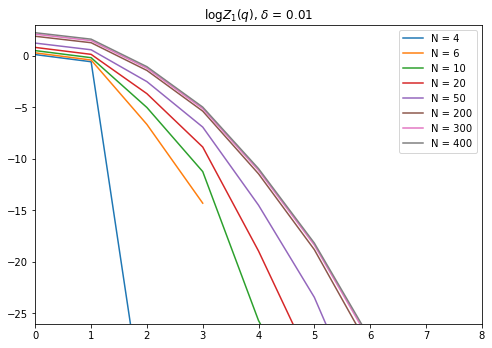

In [62]:
plt.plot(q_array0[q_array0.size//2:q_array0.size] - q_array0.size//2, Log_Zq_0,  label = "N = " + str(N_cells0))

plt.plot(q_array1[q_array1.size//2:q_array1.size] - q_array1.size//2, Log_Zq_1,  label = "N = " + str(N_cells1))

plt.plot(q_array2[q_array2.size//2:q_array2.size] - q_array2.size//2, Log_Zq_2,  label = "N = " + str(N_cells2))

plt.plot(q_array3[q_array3.size//2:q_array3.size] - q_array3.size//2, Log_Zq_3,  label = "N = " + str(N_cells3))

plt.plot(q_array4[q_array4.size//2:q_array4.size] - q_array4.size//2, Log_Zq_4,  label = "N = " + str(N_cells4))

plt.plot(q_array5[q_array5.size//2:q_array5.size] - q_array5.size//2, Log_Zq_5,  label = "N = " + str(N_cells5))

plt.plot(q_array6[q_array6.size//2:q_array6.size] - q_array6.size//2, Log_Zq_6,  label = "N = " + str(N_cells6))

plt.plot(q_array7[q_array7.size//2:q_array7.size] - q_array7.size//2, Log_Zq_7,  label = "N = " + str(N_cells7))
plt.legend()

plt.ylim([-26,3])
plt.xlim([0,8])
plt.title("$\log Z_1 (q)$, $\delta$ = " + str(Delta))
plt.rcParams["figure.figsize"] = (10,5)

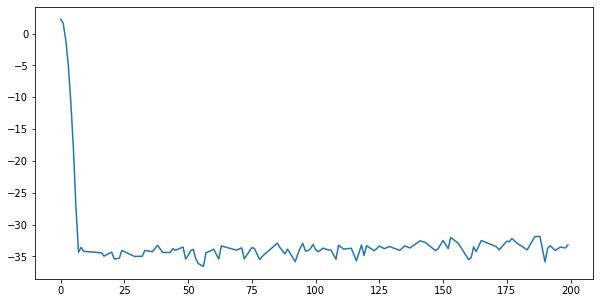

In [63]:
y = Log_Zq_7[~np.isnan(Log_Zq_7)]
x = q_array7[q_array7.size//2:q_array7.size] - q_array7.size//2
x = x[~np.isnan(Log_Zq_7)]
plt.plot(x, y)

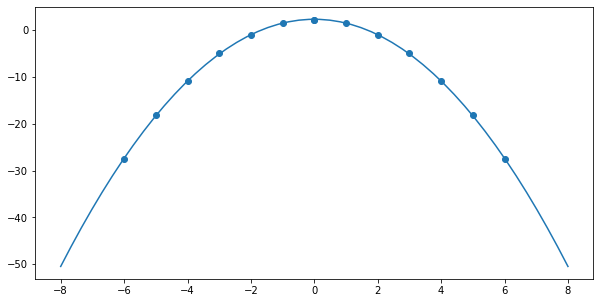

[-8.25152549e-01 -1.31672329e-16  2.33114689e+00]


In [64]:
#polynomial fit with degree = 2 for N = 400
coeff = np.polyfit(np.concatenate((-x[0:7],x[0:7])), np.concatenate((y[0:7], y[0:7])), 2)
model = np.poly1d(coeff)

#add fitted polynomial line to scatterplot
polyline = np.linspace(-8, 8, 50)
plt.scatter(np.concatenate((-x[0:7],x[0:7])), np.concatenate((y[0:7], y[0:7])))
plt.plot(polyline, model(polyline))
plt.show()
print(coeff)

In [65]:
def sigma(array):
    return np.sqrt(1/array*(-2))

In [66]:
#for N = 4

q_new_0 = q_array0[q_array0.size//2:q_array0.size] - q_array0.size//2
coeff_0 = np.polyfit(np.concatenate((-q_new_0,q_new_0)),np.concatenate((Log_Zq_0,Log_Zq_0)), 2)

#for N = 6

q_new_1 = q_array1[q_array1.size//2:q_array1.size] - q_array1.size//2
coeff_1 = np.polyfit(np.concatenate((-q_new_1,q_new_1)),np.concatenate((Log_Zq_1,Log_Zq_1)), 2)

#for N = 10

q_new_2 = q_array2[q_array2.size//2:q_array2.size] - q_array2.size//2
coeff_2 = np.polyfit(np.concatenate((-q_new_2,q_new_2)),np.concatenate((Log_Zq_2,Log_Zq_2)), 2)

#for N = 20

q_new_3 = q_array3[q_array3.size//2:q_array3.size] - q_array3.size//2
Log_Zq_3_new = Log_Zq_3[~np.isnan(Log_Zq_3)]
q_new_3 = q_new_3[~np.isnan(Log_Zq_3)]

coeff_3 = np.polyfit(np.concatenate((-q_new_3[0:6],q_new_3[0:6])),np.concatenate((Log_Zq_3_new[0:6],Log_Zq_3_new[0:6])), 2)

#for N = 50

q_new_4 = q_array4[q_array4.size//2:q_array4.size] - q_array4.size//2
Log_Zq_4_new = Log_Zq_4[~np.isnan(Log_Zq_4)]
q_new_4 = q_new_4[~np.isnan(Log_Zq_4)]

coeff_4 = np.polyfit(np.concatenate((-q_new_4[0:7],q_new_4[0:7])),np.concatenate((Log_Zq_4_new[0:7],Log_Zq_4_new[0:7])), 2)


#for N = 200

q_new_5 = q_array5[q_array5.size//2:q_array5.size] - q_array5.size//2
Log_Zq_5_new = Log_Zq_5[~np.isnan(Log_Zq_5)]
q_new_5 = q_new_5[~np.isnan(Log_Zq_5)]

coeff_5 = np.polyfit(np.concatenate((-q_new_5[0:7],q_new_5[0:7])),np.concatenate((Log_Zq_5_new[0:7],Log_Zq_5_new[0:7])), 2)

#for N = 300

q_new_6 = q_array6[q_array6.size//2:q_array6.size] - q_array6.size//2
Log_Zq_6_new = Log_Zq_6[~np.isnan(Log_Zq_6)]
q_new_6 = q_new_6[~np.isnan(Log_Zq_6)]

coeff_6 = np.polyfit(np.concatenate((-q_new_6[0:7],q_new_6[0:7])),np.concatenate((Log_Zq_6_new[0:7],Log_Zq_6_new[0:7])), 2)

#for N = 400


q_new_7 = q_array7[q_array7.size//2:q_array7.size] - q_array7.size//2
Log_Zq_7_new = Log_Zq_7[~np.isnan(Log_Zq_7)]
q_new_7 = q_new_7[~np.isnan(Log_Zq_7)]

coeff_7 = np.polyfit(np.concatenate((-q_new_7[0:7],q_new_7[0:7])),np.concatenate((Log_Zq_7_new[0:7],Log_Zq_7_new[0:7])), 2)

#func = lambda x: coeff_7[0]*x**2 + coeff_7[1]*x + coeff_7[2]
#x_array = np.linspace(-6,6, 50)

#plt.scatter(np.concatenate((-q_new_7[0:7],q_new_7[0:7])), np.concatenate((Log_Zq_7_new[0:7],Log_Zq_7_new[0:7])))
#plt.plot(np.concatenate((-q_new_7[0:7],q_new_7[0:7])), func(np.concatenate((-q_new_7[0:7],q_new_7[0:7]))))
#plt.plot(x_array, func(x_array))
#plt.show()

Text(0.5, 1.0, '$\\sigma$(N), $\\delta$ = 0.01')

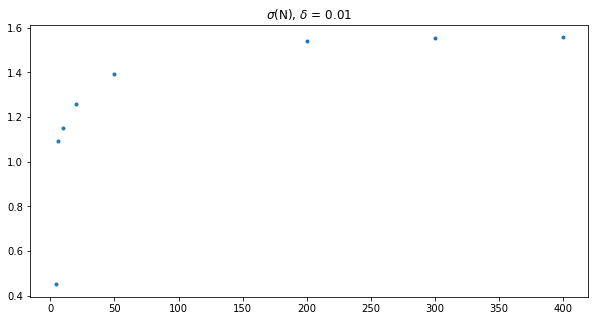

In [67]:
sigma_array = np.array(sigma(np.array([coeff_0[0], coeff_1[0], coeff_2[0], coeff_3[0], coeff_4[0], coeff_5[0], 
                                       coeff_6[0], coeff_7[0]])))
N_array = np.array([4, 6, 10, 20, 50, 200, 300, 400])
plt.plot(N_array, sigma_array, ".")
#plt.xscale('log')
plt.title("$\sigma$(N), $\delta$ = 0.01")

### $\delta$ = 0.02

In [68]:
critical_length(0.02)

[24.996666311036567, 26]

In [70]:
N_cells01 = 4
N01  = N_cells01 + 1
type_num = 1

Delta1 = 0.02
alpha_array01 =  np.array([i for i in range(N01)])

A01 = eigval_corr_matrix(N_cells01, Delta1, N_cells01//2)
Z_n_array01 = np.array([Z_n_real(type_num, alpha_array01[i], A01, N_cells01) for i in range(N01//2 + 1)])
q_array01 = np.array([i for i in range(N01)])

In [71]:
N_cells11 = 6
N11 = N_cells11 + 1
type_num = 1

Delta1 = 0.02
alpha_array11 =  np.array([i for i in range(N11)])

A11 = eigval_corr_matrix(N_cells11, Delta1, N_cells11//2)
Z_n_array11 = np.array([Z_n_real(type_num, alpha_array11[i], A11, N_cells11) for i in range(N11//2 + 1)])
q_array11 = np.array([i for i in range(N11)])

In [72]:
N_cells21 = 10
N21  = N_cells21 + 1
type_num = 1

Delta1 = 0.02
alpha_array21 =  np.array([i for i in range(N21)])

A21 = eigval_corr_matrix(N_cells21, Delta1, N_cells21//2)
Z_n_array21 = np.array([Z_n_real(type_num, alpha_array21[i], A21, N_cells21) for i in range(N21//2 + 1)])
q_array21 = np.array([i for i in range(N21)])

In [73]:
N_cells31 = 20
N31  = N_cells31 + 1
type_num = 1

Delta1 = 0.02
alpha_array31 =  np.array([i for i in range(N31)])

A31 = eigval_corr_matrix(N_cells31, Delta1, N_cells31//2)
Z_n_array31 = np.array([Z_n_real(type_num, alpha_array31[i], A31, N_cells31) for i in range(N31//2 + 1)])
q_array31 = np.array([i for i in range(N31)])

In [74]:
N_cells41 = 50
N41 = N_cells41 + 1
type_num = 1

Delta1 = 0.02
alpha_array41 =  np.array([i for i in range(N41)])

from datetime import datetime
start_time = datetime.now()
A41 = eigval_corr_matrix(N_cells41, Delta1, N_cells41//2)

Z_n_array41 = np.array([Z_n_real(type_num, alpha_array41[i], A41, N_cells41) for i in range(N41//2 + 1)])
q_array41 = np.array([i for i in range(N41)])

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:00.452947


In [75]:
N_cells51 = 200
N51  = N_cells51 + 1
type_num = 1

Delta1 = 0.02
alpha_array51 =  np.array([i for i in range(N51)])

from datetime import datetime
start_time = datetime.now()
A51 = eigval_corr_matrix(N_cells51, Delta1, N_cells51//2)

Z_n_array51 = np.array([Z_n_real(type_num, alpha_array51[i], A51, N_cells51) for i in range(N51//2 + 1)])
q_array51 = np.array([i for i in range(N51)])

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:26.343525


In [76]:
N_cells61 = 300
N61  = N_cells61 + 1
type_num = 1

Delta1 = 0.02
alpha_array61 =  np.array([i for i in range(N61)])

from datetime import datetime
start_time = datetime.now()
A61 = eigval_corr_matrix(N_cells61, Delta1, N_cells61//2)

Z_n_array61 = np.array([Z_n_real(type_num, alpha_array61[i], A61, N_cells61) for i in range(N61//2 + 1)])
q_array61 = np.array([i for i in range(N61)])


end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:01:28.155061


In [77]:
N_cells71 = 400
N71 = N_cells71 + 1
type_num = 1

Delta1 = 0.02
alpha_array71 =  np.array([i for i in range(N71)])

from datetime import datetime
start_time = datetime.now()
A71 = eigval_corr_matrix(N_cells71, Delta1, N_cells71//2)

Z_n_array71 = np.array([Z_n_real(type_num, alpha_array71[i], A71, N_cells71) for i in range(N71//2 + 1)])
q_array71 = np.array([i for i in range(N71)])


end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:03:32.749696


In [78]:
Log_Zq_01 = np.log(DFT_half(Z_n_array01)[q_array01.size//2:q_array01.size])

Log_Zq_11 = np.log(DFT_half(Z_n_array11)[q_array11.size//2:q_array11.size])

Log_Zq_21 = np.log(DFT_half(Z_n_array21)[q_array21.size//2:q_array21.size])

Log_Zq_31 = np.log(DFT_half(Z_n_array31)[q_array31.size//2:q_array31.size])

Log_Zq_41 = np.log(DFT_half(Z_n_array41)[q_array41.size//2:q_array41.size])

Log_Zq_51 = np.log(DFT_half(Z_n_array51)[q_array51.size//2:q_array51.size])

Log_Zq_61 = np.log(DFT_half(Z_n_array61)[q_array61.size//2:q_array61.size]) 

Log_Zq_71 = np.log(DFT_half(Z_n_array71)[q_array71.size//2:q_array71.size]) 

C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys
C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':
C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()
C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]
C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


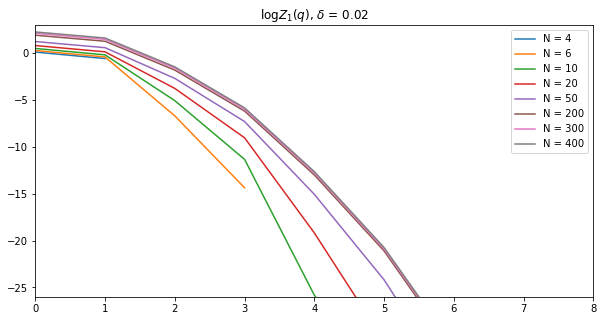

In [79]:
plt.plot(q_array01[q_array01.size//2:q_array01.size] - q_array01.size//2, Log_Zq_01,  label = "N = " + str(N_cells01))

plt.plot(q_array11[q_array11.size//2:q_array11.size] - q_array11.size//2, Log_Zq_11,  label = "N = " + str(N_cells11))


plt.plot(q_array21[q_array21.size//2:q_array21.size] - q_array21.size//2, Log_Zq_21,  label = "N = " + str(N_cells21))


plt.plot(q_array31[q_array31.size//2:q_array31.size] - q_array31.size//2, Log_Zq_31,  label = "N = " + str(N_cells31))


plt.plot(q_array41[q_array41.size//2:q_array41.size] - q_array41.size//2, Log_Zq_41,  label = "N = " + str(N_cells41))


plt.plot(q_array51[q_array51.size//2:q_array51.size] - q_array51.size//2, Log_Zq_51,  label = "N = " + str(N_cells51))


plt.plot(q_array61[q_array61.size//2:q_array61.size] - q_array61.size//2, Log_Zq_61,  label = "N = " + str(N_cells61))


plt.plot(q_array71[q_array71.size//2:q_array71.size] - q_array71.size//2, Log_Zq_71,  label = "N = " + str(N_cells71))
plt.legend()

plt.ylim([-26,3])
plt.xlim([0,8])
plt.title("$\log Z_1 (q)$, $\delta$ = " + str(Delta1))
plt.rcParams["figure.figsize"] = (10,5)

In [80]:
#for N = 4

#q_new_01 = q_array01[q_array01.size//2:q_array01.size] - q_array01.size//2
#coeff_01 = np.polyfit(np.concatenate((-q_new_01,q_new_01)),np.concatenate((Log_Zq_01,Log_Zq_01)), 2)

#for N = 6

q_new_11 = q_array11[q_array11.size//2:q_array11.size] - q_array11.size//2
coeff_11 = np.polyfit(np.concatenate((-q_new_11,q_new_11)),np.concatenate((Log_Zq_11,Log_Zq_11)), 2)

#for N = 10

q_new_21 = q_array21[q_array21.size//2:q_array21.size] - q_array21.size//2
coeff_21 = np.polyfit(np.concatenate((-q_new_21,q_new_21)),np.concatenate((Log_Zq_21,Log_Zq_21)), 2)

#for N = 20

q_new_31 = q_array31[q_array31.size//2:q_array31.size] - q_array31.size//2
Log_Zq_31_new = Log_Zq_31[~np.isnan(Log_Zq_31)]
q_new_31 = q_new_31[~np.isnan(Log_Zq_31)]

coeff_31 = np.polyfit(np.concatenate((-q_new_31[0:6],q_new_31[0:6])),np.concatenate((Log_Zq_31_new[0:6],Log_Zq_31_new[0:6])), 2)

#for N = 50

q_new_41 = q_array41[q_array41.size//2:q_array41.size] - q_array41.size//2
Log_Zq_41_new = Log_Zq_41[~np.isnan(Log_Zq_41)]
q_new_41 = q_new_41[~np.isnan(Log_Zq_41)]

coeff_41 = np.polyfit(np.concatenate((-q_new_41[0:7],q_new_41[0:7])),np.concatenate((Log_Zq_41_new[0:7],Log_Zq_41_new[0:7])), 2)


#for N = 200

q_new_51 = q_array51[q_array51.size//2:q_array51.size] - q_array51.size//2
Log_Zq_51_new = Log_Zq_51[~np.isnan(Log_Zq_51)]
q_new_51 = q_new_51[~np.isnan(Log_Zq_51)]

coeff_51 = np.polyfit(np.concatenate((-q_new_51[0:7],q_new_51[0:7])),np.concatenate((Log_Zq_51_new[0:7],Log_Zq_51_new[0:7])), 2)

#for N = 300

q_new_61 = q_array61[q_array61.size//2:q_array61.size] - q_array61.size//2
Log_Zq_61_new = Log_Zq_61[~np.isnan(Log_Zq_61)]
q_new_61 = q_new_61[~np.isnan(Log_Zq_61)]

coeff_61 = np.polyfit(np.concatenate((-q_new_61[0:7],q_new_61[0:7])),np.concatenate((Log_Zq_61_new[0:7],Log_Zq_61_new[0:7])), 2)

#for N = 400


q_new_71 = q_array71[q_array71.size//2:q_array71.size] - q_array71.size//2
Log_Zq_71_new = Log_Zq_71[~np.isnan(Log_Zq_71)]
q_new_71 = q_new_71[~np.isnan(Log_Zq_71)]

coeff_71 = np.polyfit(np.concatenate((-q_new_71[0:7],q_new_71[0:7])),np.concatenate((Log_Zq_71_new[0:7],Log_Zq_71_new[0:7])), 2)

#func = lambda x: coeff_7[0]*x**2 + coeff_7[1]*x + coeff_7[2]
#x_array = np.linspace(-6,6, 50)

#plt.scatter(np.concatenate((-q_new_7[0:7],q_new_7[0:7])), np.concatenate((Log_Zq_7_new[0:7],Log_Zq_7_new[0:7])))
#plt.plot(np.concatenate((-q_new_7[0:7],q_new_7[0:7])), func(np.concatenate((-q_new_7[0:7],q_new_7[0:7]))))
#plt.plot(x_array, func(x_array))
#plt.show()

Text(0.5, 1.0, '$\\sigma$(N), $\\delta$ = 0.02')

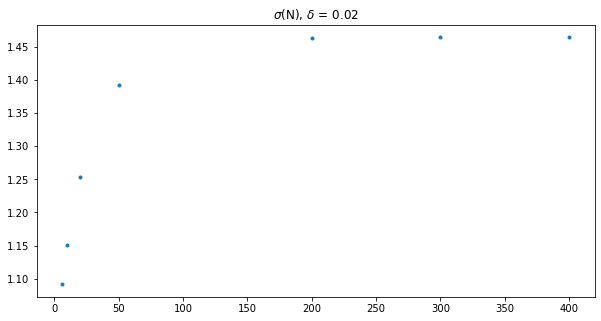

In [81]:
sigma_array1 = sigma(np.array([coeff_11[0], coeff_21[0], coeff_31[0], coeff_41[0], coeff_51[0], coeff_61[0], coeff_71[0]]))
N_array = np.array([6, 10, 20, 50, 200, 300, 400])
plt.plot(N_array, sigma_array1, ".")
#plt.xscale('log')
plt.title("$\sigma$(N), $\delta$ = 0.02")

sigma_array1 = np.array([coeff_11[0], coeff_21[0], coeff_31[0], coeff_41[0], coeff_51[0], coeff_61[0], coeff_71[0]])
N_array1 = np.array([6, 10, 20, 50, 200, 300, 400])
plt.plot(N_array1, sigma_array1, ".")
plt.title("$\sigma$(N), $\delta$ = 0.02")

## $\delta$ = 0 

In [82]:
N_cells02 = 4
N02  = N_cells02 + 1
type_num = 1

Delta2 = 0
alpha_array02 =  np.array([i for i in range(N02)])

A02 = eigval_corr_matrix(N_cells02, Delta2, N_cells02//2)
Z_n_array02 = np.array([Z_n_real(type_num, alpha_array02[i], A02, N_cells02) for i in range(N02//2 + 1)])
q_array02 = np.array([i for i in range(N02)])

In [83]:
N_cells12 = 6
N12 = N_cells12 + 1
type_num = 1

Delta2 = 0
alpha_array12 =  np.array([i for i in range(N12)])

A12 = eigval_corr_matrix(N_cells12, Delta2, N_cells12//2)
Z_n_array12 = np.array([Z_n_real(type_num, alpha_array12[i], A12, N_cells12) for i in range(N12//2 + 1)])
q_array12 = np.array([i for i in range(N12)])

In [84]:
N_cells22 = 10
N22  = N_cells22 + 1
type_num = 1

Delta2 = 0
alpha_array22 =  np.array([i for i in range(N22)])

A22 = eigval_corr_matrix(N_cells22, Delta2, N_cells22//2)
Z_n_array22 = np.array([Z_n_real(type_num, alpha_array22[i], A22, N_cells22) for i in range(N22//2 + 1)])
q_array22 = np.array([i for i in range(N22)])

In [85]:
N_cells32 = 20
N32  = N_cells32 + 1
type_num = 1

Delta2 = 0
alpha_array32 =  np.array([i for i in range(N32)])

A32 = eigval_corr_matrix(N_cells32, Delta2, N_cells32//2)
Z_n_array32 = np.array([Z_n_real(type_num, alpha_array32[i], A32, N_cells32) for i in range(N32//2 + 1)])
q_array32 = np.array([i for i in range(N32)])

In [86]:
N_cells42 = 50
N42 = N_cells42 + 1
type_num = 1

Delta2 = 0
alpha_array42 =  np.array([i for i in range(N42)])

from datetime import datetime
start_time = datetime.now()
A42 = eigval_corr_matrix(N_cells42, Delta2, N_cells42//2)

Z_n_array42 = np.array([Z_n_real(type_num, alpha_array42[i], A42, N_cells42) for i in range(N42//2 + 1)])
q_array42 = np.array([i for i in range(N42)])

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:00.552090


In [87]:
N_cells52 = 200
N52  = N_cells52 + 1
type_num = 1

Delta2 = 0
alpha_array52 =  np.array([i for i in range(N52)])

from datetime import datetime
start_time = datetime.now()
A52 = eigval_corr_matrix(N_cells52, Delta2, N_cells52//2)

Z_n_array52 = np.array([Z_n_real(type_num, alpha_array52[i], A52, N_cells52) for i in range(N52//2 + 1)])
q_array52 = np.array([i for i in range(N52)])

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:26.444715


In [88]:
N_cells62 = 300
N62  = N_cells62 + 1
type_num = 1

Delta2 = 0
alpha_array62 =  np.array([i for i in range(N62)])

from datetime import datetime
start_time = datetime.now()
A62 = eigval_corr_matrix(N_cells62, Delta2, N_cells62//2)

Z_n_array62 = np.array([Z_n_real(type_num, alpha_array62[i], A62, N_cells62) for i in range(N62//2 + 1)])
q_array62 = np.array([i for i in range(N62)])


end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:01:26.326664


In [89]:
N_cells72 = 400
N72 = N_cells72 + 1
type_num = 1

Delta2 = 0
alpha_array72 =  np.array([i for i in range(N72)])

from datetime import datetime
start_time = datetime.now()
A72 = eigval_corr_matrix(N_cells72, Delta2, N_cells72//2)

Z_n_array72 = np.array([Z_n_real(type_num, alpha_array72[i], A72, N_cells72) for i in range(N72//2 + 1)])
q_array72 = np.array([i for i in range(N72)])


end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:03:25.267302


In [90]:
Log_Zq_02 = np.log(DFT_half(Z_n_array02)[q_array02.size//2:q_array02.size])

Log_Zq_12 = np.log(DFT_half(Z_n_array12)[q_array12.size//2:q_array12.size])

Log_Zq_22 = np.log(DFT_half(Z_n_array22)[q_array22.size//2:q_array22.size])

Log_Zq_32 = np.log(DFT_half(Z_n_array32)[q_array32.size//2:q_array32.size])

Log_Zq_42 = np.log(DFT_half(Z_n_array42)[q_array42.size//2:q_array42.size])

Log_Zq_52 = np.log(DFT_half(Z_n_array52)[q_array52.size//2:q_array52.size])

Log_Zq_62 = np.log(DFT_half(Z_n_array62)[q_array62.size//2:q_array62.size]) 

Log_Zq_72 = np.log(DFT_half(Z_n_array72)[q_array72.size//2:q_array72.size]) 

C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys
C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':
C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()
C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]
C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


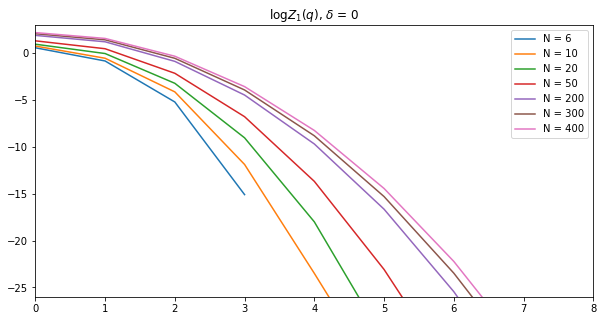

In [91]:
plt.plot(q_array12[q_array12.size//2:q_array12.size] - q_array12.size//2, Log_Zq_12,  label = "N = " + str(N_cells12))


plt.plot(q_array22[q_array22.size//2:q_array22.size] - q_array22.size//2, Log_Zq_22,  label = "N = " + str(N_cells22))


plt.plot(q_array32[q_array32.size//2:q_array32.size] - q_array32.size//2, Log_Zq_32,  label = "N = " + str(N_cells32))


plt.plot(q_array42[q_array42.size//2:q_array42.size] - q_array42.size//2, Log_Zq_42,  label = "N = " + str(N_cells42))


plt.plot(q_array52[q_array52.size//2:q_array52.size] - q_array52.size//2, Log_Zq_52,  label = "N = " + str(N_cells52))


plt.plot(q_array62[q_array62.size//2:q_array62.size] - q_array62.size//2, Log_Zq_62,  label = "N = " + str(N_cells62))


plt.plot(q_array72[q_array72.size//2:q_array72.size] - q_array72.size//2, Log_Zq_72,  label = "N = " + str(N_cells72))
plt.legend()

plt.ylim([-26,3])
plt.xlim([0,8])
plt.title("$\log Z_1 (q)$, $\delta$ = " + str(Delta2))
plt.rcParams["figure.figsize"] = (10,5)

In [92]:
#for N = 4

#q_new_01 = q_array01[q_array01.size//2:q_array01.size] - q_array01.size//2
#coeff_01 = np.polyfit(np.concatenate((-q_new_01,q_new_01)),np.concatenate((Log_Zq_01,Log_Zq_01)), 2)

#for N = 6

q_new_12 = q_array12[q_array12.size//2:q_array12.size] - q_array12.size//2
coeff_12 = np.polyfit(np.concatenate((-q_new_12,q_new_12)),np.concatenate((Log_Zq_12,Log_Zq_12)), 2)

#for N = 10

q_new_22 = q_array22[q_array22.size//2:q_array22.size] - q_array22.size//2
coeff_22 = np.polyfit(np.concatenate((-q_new_22,q_new_22)),np.concatenate((Log_Zq_22,Log_Zq_22)), 2)

#for N = 20

q_new_32 = q_array32[q_array32.size//2:q_array32.size] - q_array32.size//2
Log_Zq_32_new = Log_Zq_32[~np.isnan(Log_Zq_32)]
q_new_32 = q_new_32[~np.isnan(Log_Zq_32)]

coeff_32 = np.polyfit(np.concatenate((-q_new_32[0:6],q_new_32[0:6])),np.concatenate((Log_Zq_32_new[0:6],Log_Zq_32_new[0:6])), 2)

#for N = 50

q_new_42 = q_array42[q_array42.size//2:q_array42.size] - q_array42.size//2
Log_Zq_42_new = Log_Zq_42[~np.isnan(Log_Zq_42)]
q_new_42 = q_new_42[~np.isnan(Log_Zq_42)]

coeff_42 = np.polyfit(np.concatenate((-q_new_42[0:7],q_new_42[0:7])),np.concatenate((Log_Zq_42_new[0:7],Log_Zq_42_new[0:7])), 2)


#for N = 200

q_new_52 = q_array52[q_array52.size//2:q_array52.size] - q_array52.size//2
Log_Zq_52_new = Log_Zq_52[~np.isnan(Log_Zq_52)]
q_new_52 = q_new_52[~np.isnan(Log_Zq_52)]

coeff_52 = np.polyfit(np.concatenate((-q_new_52[0:7],q_new_52[0:7])),np.concatenate((Log_Zq_52_new[0:7],Log_Zq_52_new[0:7])), 2)

#for N = 300

q_new_62 = q_array62[q_array62.size//2:q_array62.size] - q_array62.size//2
Log_Zq_62_new = Log_Zq_62[~np.isnan(Log_Zq_62)]
q_new_62 = q_new_62[~np.isnan(Log_Zq_62)]

coeff_62 = np.polyfit(np.concatenate((-q_new_62[0:7],q_new_62[0:7])),np.concatenate((Log_Zq_62_new[0:7],Log_Zq_62_new[0:7])), 2)

#for N = 400


q_new_72 = q_array72[q_array72.size//2:q_array72.size] - q_array72.size//2
Log_Zq_72_new = Log_Zq_72[~np.isnan(Log_Zq_72)]
q_new_72 = q_new_72[~np.isnan(Log_Zq_72)]

coeff_72 = np.polyfit(np.concatenate((-q_new_72[0:7],q_new_72[0:7])),np.concatenate((Log_Zq_72_new[0:7],Log_Zq_72_new[0:7])), 2)

#func = lambda x: coeff_7[0]*x**2 + coeff_7[1]*x + coeff_7[2]
#x_array = np.linspace(-6,6, 50)

#plt.scatter(np.concatenate((-q_new_7[0:7],q_new_7[0:7])), np.concatenate((Log_Zq_7_new[0:7],Log_Zq_7_new[0:7])))
#plt.plot(np.concatenate((-q_new_7[0:7],q_new_7[0:7])), func(np.concatenate((-q_new_7[0:7],q_new_7[0:7]))))
#plt.plot(x_array, func(x_array))
#plt.show()

Text(0.5, 1.0, '$\\sigma$(N), $\\delta$ = 0')

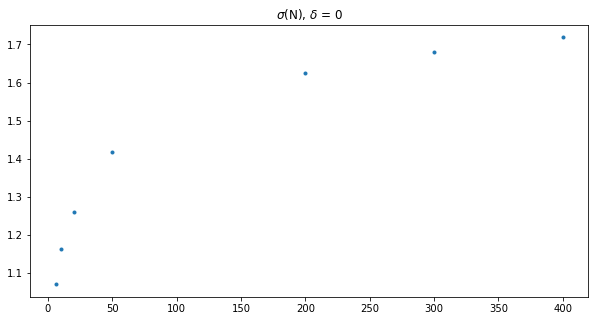

In [93]:
sigma_array2 = sigma(np.array([coeff_12[0], coeff_22[0], coeff_32[0], coeff_42[0], coeff_52[0], coeff_62[0], coeff_72[0]]))
N_array = np.array([6, 10, 20, 50, 200, 300, 400])
plt.plot(N_array, sigma_array2, ".")
#plt.xscale('log')
plt.title("$\sigma$(N), $\delta$ = 0")

## $N_A$ dependence

## $\delta$ = 0.02

In [94]:
N_cells_NA = 500
N_NA = N_cells_NA + 1
type_num = 1

Delta_NA = 0.02
alpha_array_NA =  np.array([i for i in range(N_NA)])
q_array_NA = np.array([i for i in range(N_NA)])

from datetime import datetime
start_time = datetime.now()


#N_A = 4

NA0 = 4
A_NA0 = eigval_corr_matrix(N_cells_NA, Delta_NA, NA0)
Z_n_array_NA0 = np.array([Z_n_real(type_num, alpha_array_NA[i], A_NA0, N_cells_NA) for i in range(N_NA//2  + 1)])

In [95]:
#N_A = 10

NA1 = 10
A_NA1 = eigval_corr_matrix(N_cells_NA, Delta_NA, NA1)
Z_n_array_NA1 = np.array([Z_n_real(type_num, alpha_array_NA[i], A_NA1, N_cells_NA) for i in range(N_NA//2 + 1)])

In [96]:
#N_A = 20

NA2 = 20
A_NA2 = eigval_corr_matrix(N_cells_NA, Delta_NA, NA2)
Z_n_array_NA2 = np.array([Z_n_real(type_num, alpha_array_NA[i], A_NA2, N_cells_NA) for i in range(N_NA//2 + 1)])

In [97]:
#N_A = 50

NA3 = 50
A_NA3 = eigval_corr_matrix(N_cells_NA, Delta_NA, NA3)
Z_n_array_NA3 = np.array([Z_n_real(type_num, alpha_array_NA[i], A_NA3, N_cells_NA) for i in range(N_NA//2 + 1)])

In [98]:
#N_A = 100

NA4 = 100
A_NA4 = eigval_corr_matrix(N_cells_NA, Delta_NA, NA4)
Z_n_array_NA4 = np.array([Z_n_real(type_num, alpha_array_NA[i], A_NA4, N_cells_NA) for i in range(N_NA//2 + 1)])

In [99]:
#N_A = 150


start_time = datetime.now()

NA5 = 150
A_NA5 = eigval_corr_matrix(N_cells_NA, Delta_NA, NA5)
Z_n_array_NA5 = np.array([Z_n_real(type_num, alpha_array_NA[i], A_NA5, N_cells_NA) for i in range(N_NA//2 + 1)])

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:02:35.183695


In [100]:
#N_A = 200

start_time = datetime.now()

NA6 = 200
A_NA6 = eigval_corr_matrix(N_cells_NA, Delta_NA, NA6)
Z_n_array_NA6 = np.array([Z_n_real(type_num, alpha_array_NA[i], A_NA6, N_cells_NA) for i in range(N_NA//2 + 1)])

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:04:20.767356


In [101]:
#N_A = 250

start_time = datetime.now()

NA7 = 250
A_NA7 = eigval_corr_matrix(N_cells_NA, Delta_NA, NA7)
Z_n_array_NA7 = np.array([Z_n_real(type_num, alpha_array_NA[i], A_NA7, N_cells_NA) for i in range(N_NA//2 + 1)])

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:06:49.204439


In [102]:
print(critical_length(0.02))

[24.996666311036567, 26]


In [103]:
Log_Zq_NA0 = np.log(DFT_half(Z_n_array_NA0)[q_array_NA.size//2:q_array_NA.size])

Log_Zq_NA1 = np.log(DFT_half(Z_n_array_NA1)[q_array_NA.size//2:q_array_NA.size])

Log_Zq_NA2 = np.log(DFT_half(Z_n_array_NA2)[q_array_NA.size//2:q_array_NA.size])

Log_Zq_NA3 = np.log(DFT_half(Z_n_array_NA3)[q_array_NA.size//2:q_array_NA.size])

Log_Zq_NA4 = np.log(DFT_half(Z_n_array_NA4)[q_array_NA.size//2:q_array_NA.size])

Log_Zq_NA5 = np.log(DFT_half(Z_n_array_NA5)[q_array_NA.size//2:q_array_NA.size])

Log_Zq_NA6 = np.log(DFT_half(Z_n_array_NA6)[q_array_NA.size//2:q_array_NA.size])

Log_Zq_NA7 = np.log(DFT_half(Z_n_array_NA7)[q_array_NA.size//2:q_array_NA.size])

C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys
C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':
C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()
C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarn

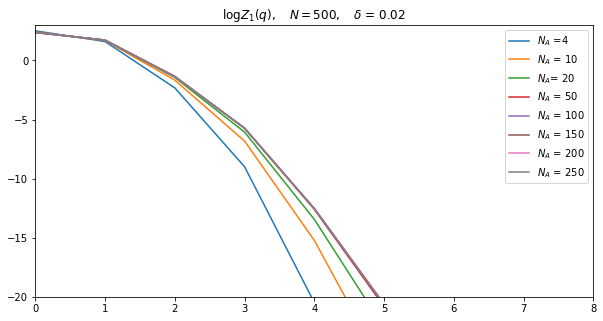

In [104]:
plt.plot(q_array_NA[q_array_NA.size//2:q_array_NA.size] - q_array_NA.size//2, Log_Zq_NA0, label = "$N_A$ =" + str(NA0))
plt.plot(q_array_NA[q_array_NA.size//2:q_array_NA.size] - q_array_NA.size//2, Log_Zq_NA1, label = "$N_A$ = " + str(NA1))
plt.plot(q_array_NA[q_array_NA.size//2:q_array_NA.size] - q_array_NA.size//2, Log_Zq_NA2, label = "$N_A$= " + str(NA2))
plt.plot(q_array_NA[q_array_NA.size//2:q_array_NA.size] - q_array_NA.size//2, Log_Zq_NA3, label = "$N_A$ = " + str(NA3))
plt.plot(q_array_NA[q_array_NA.size//2:q_array_NA.size] - q_array_NA.size//2, Log_Zq_NA4, label = "$N_A$ = " + str(NA4))
plt.plot(q_array_NA[q_array_NA.size//2:q_array_NA.size] - q_array_NA.size//2, Log_Zq_NA5, label = "$N_A$ = " + str(NA5))
plt.plot(q_array_NA[q_array_NA.size//2:q_array_NA.size] - q_array_NA.size//2, Log_Zq_NA6, label = "$N_A$ = " + str(NA6))
plt.plot(q_array_NA[q_array_NA.size//2:q_array_NA.size] - q_array_NA.size//2, Log_Zq_NA7, label = "$N_A$ = " + str(NA7))

plt.legend()
plt.ylim([-20,3])
plt.xlim([0,8])
plt.title("$\log Z_1 (q), \quad N = 500, \quad \delta$ = " + str(Delta_NA))
plt.rcParams["figure.figsize"] = (10,5)

In [105]:
q_NA = q_array_NA[q_array_NA.size//2:q_array_NA.size] - q_array_NA.size//2


#for N = 4

Log_Zq_NA0_new = Log_Zq_NA0[~np.isnan(Log_Zq_NA0)]
q_NA0 = q_NA[~np.isnan(Log_Zq_NA0)]

coeff_NA0 = np.polyfit(np.concatenate((-q_NA0[0:5],q_NA0[0:5])),np.concatenate((Log_Zq_NA0_new[0:5],Log_Zq_NA0_new[0:5])), 2)

#N_A = 10

Log_Zq_NA1_new = Log_Zq_NA1[~np.isnan(Log_Zq_NA1)]
q_NA1 = q_NA[~np.isnan(Log_Zq_NA1)]

coeff_NA1 = np.polyfit(np.concatenate((-q_NA1[0:5],q_NA1[0:5])),np.concatenate((Log_Zq_NA1_new[0:5],Log_Zq_NA1_new[0:5])), 2)



#N_A = 20

Log_Zq_NA2_new = Log_Zq_NA2[~np.isnan(Log_Zq_NA2)]
q_NA2 = q_NA[~np.isnan(Log_Zq_NA2)]

coeff_NA2 = np.polyfit(np.concatenate((-q_NA2[0:5],q_NA2[0:5])),np.concatenate((Log_Zq_NA2_new[0:5],Log_Zq_NA2_new[0:5])), 2)



#N_A = 50

Log_Zq_NA3_new = Log_Zq_NA3[~np.isnan(Log_Zq_NA3)]
q_NA3 = q_NA[~np.isnan(Log_Zq_NA3)]

coeff_NA3 = np.polyfit(np.concatenate((-q_NA3[0:5],q_NA3[0:5])),np.concatenate((Log_Zq_NA3_new[0:5],Log_Zq_NA3_new[0:5])), 2)


#N_A = 100

Log_Zq_NA4_new = Log_Zq_NA4[~np.isnan(Log_Zq_NA4)]
q_NA4 = q_NA[~np.isnan(Log_Zq_NA4)]

coeff_NA4 = np.polyfit(np.concatenate((-q_NA4[0:5],q_NA4[0:5])),np.concatenate((Log_Zq_NA4_new[0:5],Log_Zq_NA4_new[0:5])), 2)



#N_A = 150

Log_Zq_NA5_new = Log_Zq_NA5[~np.isnan(Log_Zq_NA5)]
q_NA5 = q_NA[~np.isnan(Log_Zq_NA5)]

coeff_NA5 = np.polyfit(np.concatenate((-q_NA5[0:5],q_NA5[0:5])),np.concatenate((Log_Zq_NA5_new[0:5],Log_Zq_NA5_new[0:5])), 2)


#N_A = 200

Log_Zq_NA6_new = Log_Zq_NA6[~np.isnan(Log_Zq_NA6)]
q_NA6 = q_NA[~np.isnan(Log_Zq_NA6)]

coeff_NA6 = np.polyfit(np.concatenate((-q_NA6[0:5],q_NA6[0:5])),np.concatenate((Log_Zq_NA6_new[0:5],Log_Zq_NA6_new[0:5])), 2)


#N_A = 250

Log_Zq_NA7_new = Log_Zq_NA7[~np.isnan(Log_Zq_NA7)]
q_NA7 = q_NA[~np.isnan(Log_Zq_NA7)]

coeff_NA7 = np.polyfit(np.concatenate((-q_NA7[0:5],q_NA7[0:5])),np.concatenate((Log_Zq_NA7_new[0:5],Log_Zq_NA7_new[0:5])), 2)


Text(0.5, 1.0, '$\\sigma (N_A), N = 500 $, $\\delta$ = 0.02')

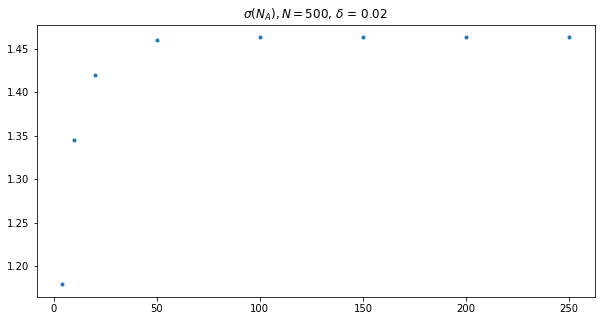

In [106]:
sigma_arrayNA = sigma(np.array([coeff_NA0[0], coeff_NA1[0], coeff_NA2[0], coeff_NA3[0], coeff_NA4[0],coeff_NA5[0], 
                                coeff_NA6[0], coeff_NA7[0]]))
N_array = np.array([4, 10, 20, 50, 100, 150, 200, 250])
plt.plot(N_array, sigma_arrayNA, ".")
#plt.xscale('log')
plt.title("$\sigma (N_A), N = 500 $, $\delta$ = 0.02")

## $\delta$ = 0.01

In [107]:
Delta_NA1 = 0.01

#N_A = 4

NA01 = 4
A_NA01 = eigval_corr_matrix(N_cells_NA, Delta_NA1, NA01)
Z_n_array_NA01 = np.array([Z_n_real(type_num, alpha_array_NA[i], A_NA01, N_cells_NA) for i in range(N_NA//2 + 1)])

In [108]:
#N_A = 10

NA11 = 10
A_NA11 = eigval_corr_matrix(N_cells_NA, Delta_NA1, NA11)
Z_n_array_NA11 = np.array([Z_n_real(type_num, alpha_array_NA[i], A_NA11, N_cells_NA) for i in range(N_NA//2  + 1)])

In [109]:
#N_A = 20

NA21 = 20
A_NA21 = eigval_corr_matrix(N_cells_NA, Delta_NA1, NA21)
Z_n_array_NA21 = np.array([Z_n_real(type_num, alpha_array_NA[i], A_NA21, N_cells_NA) for i in range(N_NA//2  + 1)])

In [110]:
#N_A = 50

NA31 = 50
A_NA31 = eigval_corr_matrix(N_cells_NA, Delta_NA1, NA31)
Z_n_array_NA31 = np.array([Z_n_real(type_num, alpha_array_NA[i], A_NA31, N_cells_NA) for i in range(N_NA//2  + 1)])

In [111]:
#N_A = 100

NA41 = 100
A_NA41 = eigval_corr_matrix(N_cells_NA, Delta_NA1, NA41)
Z_n_array_NA41 = np.array([Z_n_real(type_num, alpha_array_NA[i], A_NA41, N_cells_NA) for i in range(N_NA//2  + 1)])

In [112]:
#N_A = 150

start_time = datetime.now()

NA51 = 150
A_NA51 = eigval_corr_matrix(N_cells_NA, Delta_NA1, NA51)
Z_n_array_NA51 = np.array([Z_n_real(type_num, alpha_array_NA[i], A_NA51, N_cells_NA) for i in range(N_NA//2  + 1)])

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:02:29.499233


In [113]:
#N_A = 200

start_time = datetime.now()

NA61 = 200
A_NA61 = eigval_corr_matrix(N_cells_NA, Delta_NA1, NA61)
Z_n_array_NA61 = np.array([Z_n_real(type_num, alpha_array_NA[i], A_NA61, N_cells_NA) for i in range(N_NA//2  + 1)])

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:04:13.263818


In [114]:
#N_A = 250

start_time = datetime.now()

NA71 = 250
A_NA71 = eigval_corr_matrix(N_cells_NA, Delta_NA1, NA71)
Z_n_array_NA71 = np.array([Z_n_real(type_num, alpha_array_NA[i], A_NA71, N_cells_NA) for i in range(N_NA//2  + 1)])

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:06:48.082839


In [115]:
Log_Zq_NA01 = np.log(DFT_half(Z_n_array_NA01)[q_array_NA.size//2:q_array_NA.size])

Log_Zq_NA11 = np.log(DFT_half(Z_n_array_NA11)[q_array_NA.size//2:q_array_NA.size])

Log_Zq_NA21 = np.log(DFT_half(Z_n_array_NA21)[q_array_NA.size//2:q_array_NA.size])

Log_Zq_NA31 = np.log(DFT_half(Z_n_array_NA31)[q_array_NA.size//2:q_array_NA.size])

Log_Zq_NA41 = np.log(DFT_half(Z_n_array_NA41)[q_array_NA.size//2:q_array_NA.size])

Log_Zq_NA51 = np.log(DFT_half(Z_n_array_NA51)[q_array_NA.size//2:q_array_NA.size])

Log_Zq_NA61 = np.log(DFT_half(Z_n_array_NA61)[q_array_NA.size//2:q_array_NA.size])

Log_Zq_NA71 = np.log(DFT_half(Z_n_array_NA71)[q_array_NA.size//2:q_array_NA.size])

C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys
C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':
C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()
C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarn

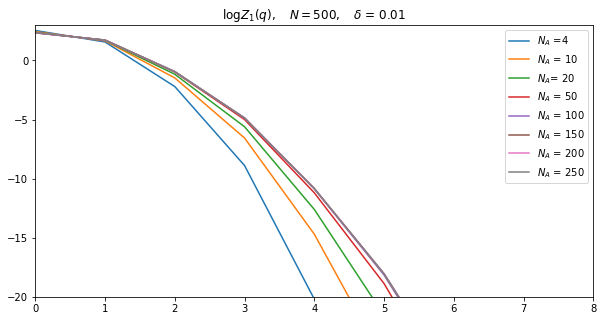

In [116]:
plt.plot(q_array_NA[q_array_NA.size//2:q_array_NA.size] - q_array_NA.size//2, Log_Zq_NA01, label = "$N_A$ =" + str(NA01))
plt.plot(q_array_NA[q_array_NA.size//2:q_array_NA.size] - q_array_NA.size//2, Log_Zq_NA11, label = "$N_A$ = " + str(NA11))
plt.plot(q_array_NA[q_array_NA.size//2:q_array_NA.size] - q_array_NA.size//2, Log_Zq_NA21, label = "$N_A$= " + str(NA21))
plt.plot(q_array_NA[q_array_NA.size//2:q_array_NA.size] - q_array_NA.size//2, Log_Zq_NA31, label = "$N_A$ = " + str(NA31))
plt.plot(q_array_NA[q_array_NA.size//2:q_array_NA.size] - q_array_NA.size//2, Log_Zq_NA41, label = "$N_A$ = " + str(NA41))
plt.plot(q_array_NA[q_array_NA.size//2:q_array_NA.size] - q_array_NA.size//2, Log_Zq_NA51, label = "$N_A$ = " + str(NA51))
plt.plot(q_array_NA[q_array_NA.size//2:q_array_NA.size] - q_array_NA.size//2, Log_Zq_NA61, label = "$N_A$ = " + str(NA61))
plt.plot(q_array_NA[q_array_NA.size//2:q_array_NA.size] - q_array_NA.size//2, Log_Zq_NA71, label = "$N_A$ = " + str(NA71))

plt.legend()
plt.ylim([-20,3])
plt.xlim([0,8])
plt.title("$\log Z_1 (q), \quad N = 500, \quad \delta$ = " + str(Delta_NA1))
plt.rcParams["figure.figsize"] = (10,5)

In [117]:
#for N = 4

Log_Zq_NA01_new = Log_Zq_NA01[~np.isnan(Log_Zq_NA01)]
q_NA01 = q_NA[~np.isnan(Log_Zq_NA01)]

coeff_NA01 = np.polyfit(np.concatenate((-q_NA01[0:5],q_NA01[0:5])),np.concatenate((Log_Zq_NA01_new[0:5],Log_Zq_NA01_new[0:5])), 2)

#N_A = 10

Log_Zq_NA11_new = Log_Zq_NA11[~np.isnan(Log_Zq_NA11)]
q_NA11 = q_NA[~np.isnan(Log_Zq_NA11)]

coeff_NA11 = np.polyfit(np.concatenate((-q_NA11[0:5],q_NA11[0:5])),np.concatenate((Log_Zq_NA11_new[0:5],Log_Zq_NA11_new[0:5])), 2)



#N_A = 20

Log_Zq_NA21_new = Log_Zq_NA21[~np.isnan(Log_Zq_NA21)]
q_NA21 = q_NA[~np.isnan(Log_Zq_NA21)]

coeff_NA21 = np.polyfit(np.concatenate((-q_NA21[0:5],q_NA21[0:5])),np.concatenate((Log_Zq_NA21_new[0:5],Log_Zq_NA21_new[0:5])), 2)



#N_A = 50

Log_Zq_NA31_new = Log_Zq_NA31[~np.isnan(Log_Zq_NA31)]
q_NA31 = q_NA[~np.isnan(Log_Zq_NA31)]

coeff_NA31 = np.polyfit(np.concatenate((-q_NA31[0:5],q_NA31[0:5])),np.concatenate((Log_Zq_NA31_new[0:5],Log_Zq_NA31_new[0:5])), 2)


#N_A = 100

Log_Zq_NA41_new = Log_Zq_NA41[~np.isnan(Log_Zq_NA41)]
q_NA41 = q_NA[~np.isnan(Log_Zq_NA41)]

coeff_NA41 = np.polyfit(np.concatenate((-q_NA41[0:5],q_NA41[0:5])),np.concatenate((Log_Zq_NA41_new[0:5],Log_Zq_NA41_new[0:5])), 2)



#N_A = 150

Log_Zq_NA51_new = Log_Zq_NA51[~np.isnan(Log_Zq_NA51)]
q_NA51 = q_NA[~np.isnan(Log_Zq_NA51)]

coeff_NA51 = np.polyfit(np.concatenate((-q_NA51[0:5],q_NA51[0:5])),np.concatenate((Log_Zq_NA51_new[0:5],Log_Zq_NA51_new[0:5])), 2)


#N_A = 200

Log_Zq_NA61_new = Log_Zq_NA61[~np.isnan(Log_Zq_NA61)]
q_NA61 = q_NA[~np.isnan(Log_Zq_NA61)]

coeff_NA61 = np.polyfit(np.concatenate((-q_NA61[0:5],q_NA61[0:5])),np.concatenate((Log_Zq_NA61_new[0:5],Log_Zq_NA61_new[0:5])), 2)


#N_A = 250

Log_Zq_NA71_new = Log_Zq_NA71[~np.isnan(Log_Zq_NA71)]
q_NA71 = q_NA[~np.isnan(Log_Zq_NA71)]

coeff_NA71 = np.polyfit(np.concatenate((-q_NA71[0:5],q_NA71[0:5])),np.concatenate((Log_Zq_NA71_new[0:5],Log_Zq_NA71_new[0:5])), 2)


Text(0.5, 1.0, '$\\sigma (N_A), N = 500 $, $\\delta$ = 0.01')

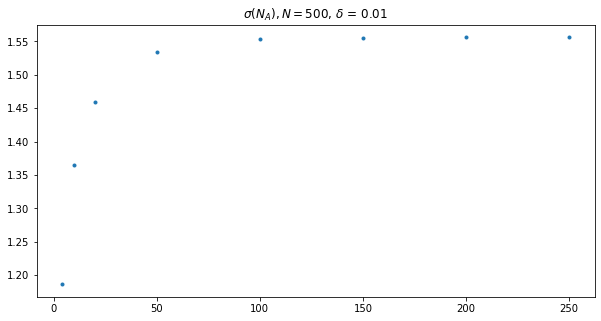

In [118]:
sigma_arrayNA1 = sigma(np.array([coeff_NA01[0], coeff_NA11[0], coeff_NA21[0], coeff_NA31[0], coeff_NA41[0], coeff_NA51[0], 
                                coeff_NA61[0], coeff_NA71[0]]))
N_array = np.array([4, 10, 20, 50, 100, 150, 200, 250])
plt.plot(N_array, sigma_arrayNA1, ".")
#plt.xscale('log')
plt.title("$\sigma (N_A), N = 500 $, $\delta$ = 0.01")

# $\delta$ = 0

In [120]:
Delta_NA2 = 0

#N_A = 4

NA02 = 4
A_NA02 = eigval_corr_matrix(N_cells_NA, Delta_NA2, NA02)
Z_n_array_NA02 = np.array([Z_n_real(type_num, alpha_array_NA[i], A_NA02, N_cells_NA) for i in range(N_NA//2 + 1)])

In [121]:
#N_A = 10

NA12 = 10
A_NA12 = eigval_corr_matrix(N_cells_NA, Delta_NA2, NA12)
Z_n_array_NA12 = np.array([Z_n_real(type_num, alpha_array_NA[i], A_NA12, N_cells_NA) for i in range(N_NA//2 + 1)])

In [122]:
#N_A = 20

NA22 = 20
A_NA22 = eigval_corr_matrix(N_cells_NA, Delta_NA2, NA22)
Z_n_array_NA22 = np.array([Z_n_real(type_num, alpha_array_NA[i], A_NA22, N_cells_NA) for i in range(N_NA//2 + 1)])

In [123]:
#N_A = 50

NA32 = 50
A_NA32 = eigval_corr_matrix(N_cells_NA, Delta_NA2, NA32)
Z_n_array_NA32 = np.array([Z_n_real(type_num, alpha_array_NA[i], A_NA32, N_cells_NA) for i in range(N_NA//2 + 1)])

In [124]:
#N_A = 100

NA42 = 100
A_NA42 = eigval_corr_matrix(N_cells_NA, Delta_NA2, NA42)
Z_n_array_NA42 = np.array([Z_n_real(type_num, alpha_array_NA[i], A_NA42, N_cells_NA) for i in range(N_NA//2 + 1)])

In [125]:
#N_A = 150

start_time = datetime.now()

NA52 = 150
A_NA52 = eigval_corr_matrix(N_cells_NA, Delta_NA2, NA52)
Z_n_array_NA52 = np.array([Z_n_real(type_num, alpha_array_NA[i], A_NA52, N_cells_NA) for i in range(N_NA//2 + 1)])

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:02:36.228933


In [126]:
#N_A = 200

start_time = datetime.now()

NA62 = 200
A_NA62 = eigval_corr_matrix(N_cells_NA, Delta_NA2, NA62)
Z_n_array_NA62 = np.array([Z_n_real(type_num, alpha_array_NA[i], A_NA62, N_cells_NA) for i in range(N_NA//2 + 1)])

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:04:27.990962


In [127]:
#N_A = 250

NA72 = 250
A_NA72 = eigval_corr_matrix(N_cells_NA, Delta_NA2, NA72)
Z_n_array_NA72 = np.array([Z_n_real(type_num, alpha_array_NA[i], A_NA72, N_cells_NA) for i in range(N_NA//2 + 1)])

In [128]:
Log_Zq_NA02 = np.log(DFT_half(Z_n_array_NA02)[q_array_NA.size//2:q_array_NA.size])

Log_Zq_NA12 = np.log(DFT_half(Z_n_array_NA12)[q_array_NA.size//2:q_array_NA.size])

Log_Zq_NA22 = np.log(DFT_half(Z_n_array_NA22)[q_array_NA.size//2:q_array_NA.size])

Log_Zq_NA32 = np.log(DFT_half(Z_n_array_NA32)[q_array_NA.size//2:q_array_NA.size])

Log_Zq_NA42 = np.log(DFT_half(Z_n_array_NA42)[q_array_NA.size//2:q_array_NA.size])

Log_Zq_NA52 = np.log(DFT_half(Z_n_array_NA52)[q_array_NA.size//2:q_array_NA.size])

Log_Zq_NA62 = np.log(DFT_half(Z_n_array_NA62)[q_array_NA.size//2:q_array_NA.size])

Log_Zq_NA72 = np.log(DFT_half(Z_n_array_NA72)[q_array_NA.size//2:q_array_NA.size])

C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys
C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':
C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()
C:\Users\MI\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarn

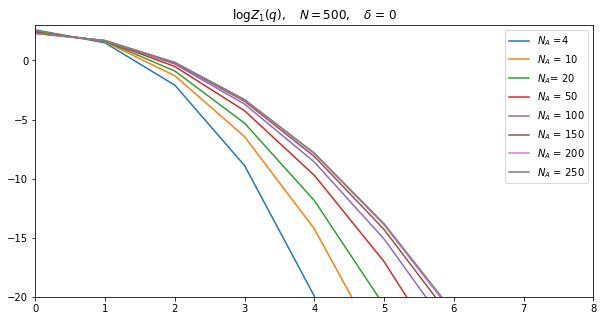

In [129]:
plt.plot(q_array_NA[q_array_NA.size//2:q_array_NA.size] - q_array_NA.size//2, Log_Zq_NA02, label = "$N_A$ =" + str(NA02))
plt.plot(q_array_NA[q_array_NA.size//2:q_array_NA.size] - q_array_NA.size//2, Log_Zq_NA12, label = "$N_A$ = " + str(NA12))
plt.plot(q_array_NA[q_array_NA.size//2:q_array_NA.size] - q_array_NA.size//2, Log_Zq_NA22, label = "$N_A$= " + str(NA22))
plt.plot(q_array_NA[q_array_NA.size//2:q_array_NA.size] - q_array_NA.size//2, Log_Zq_NA32, label = "$N_A$ = " + str(NA32))
plt.plot(q_array_NA[q_array_NA.size//2:q_array_NA.size] - q_array_NA.size//2, Log_Zq_NA42, label = "$N_A$ = " + str(NA42))
plt.plot(q_array_NA[q_array_NA.size//2:q_array_NA.size] - q_array_NA.size//2, Log_Zq_NA52, label = "$N_A$ = " + str(NA52))
plt.plot(q_array_NA[q_array_NA.size//2:q_array_NA.size] - q_array_NA.size//2, Log_Zq_NA62, label = "$N_A$ = " + str(NA62))
plt.plot(q_array_NA[q_array_NA.size//2:q_array_NA.size] - q_array_NA.size//2, Log_Zq_NA72, label = "$N_A$ = " + str(NA72))

plt.legend()
plt.ylim([-20,3])
plt.xlim([0,8])
plt.title("$\log Z_1 (q), \quad N = 500, \quad \delta$ = " + str(Delta_NA2))
plt.rcParams["figure.figsize"] = (10,5)

In [130]:
q_NA = q_array_NA[q_array_NA.size//2:q_array_NA.size] - q_array_NA.size//2

#for N = 4

Log_Zq_NA02_new = Log_Zq_NA02[~np.isnan(Log_Zq_NA02)]
q_NA02 = q_NA[~np.isnan(Log_Zq_NA02)]

coeff_NA02 = np.polyfit(np.concatenate((-q_NA02[0:5],q_NA02[0:5])),np.concatenate((Log_Zq_NA02_new[0:5],Log_Zq_NA02_new[0:5])), 2)

#N_A = 10

Log_Zq_NA12_new = Log_Zq_NA12[~np.isnan(Log_Zq_NA12)]
q_NA12 = q_NA[~np.isnan(Log_Zq_NA12)]

coeff_NA12 = np.polyfit(np.concatenate((-q_NA12[0:5],q_NA12[0:5])),np.concatenate((Log_Zq_NA12_new[0:5],Log_Zq_NA12_new[0:5])), 2)



#N_A = 20

Log_Zq_NA22_new = Log_Zq_NA22[~np.isnan(Log_Zq_NA22)]
q_NA22 = q_NA[~np.isnan(Log_Zq_NA22)]

coeff_NA22 = np.polyfit(np.concatenate((-q_NA22[0:5],q_NA22[0:5])),np.concatenate((Log_Zq_NA22_new[0:5],Log_Zq_NA22_new[0:5])), 2)



#N_A = 50

Log_Zq_NA32_new = Log_Zq_NA32[~np.isnan(Log_Zq_NA32)]
q_NA32 = q_NA[~np.isnan(Log_Zq_NA32)]

coeff_NA32 = np.polyfit(np.concatenate((-q_NA32[0:5],q_NA32[0:5])),np.concatenate((Log_Zq_NA32_new[0:5],Log_Zq_NA32_new[0:5])), 2)


#N_A = 100

Log_Zq_NA42_new = Log_Zq_NA42[~np.isnan(Log_Zq_NA42)]
q_NA42 = q_NA[~np.isnan(Log_Zq_NA42)]

coeff_NA42 = np.polyfit(np.concatenate((-q_NA42[0:5],q_NA42[0:5])),np.concatenate((Log_Zq_NA42_new[0:5],Log_Zq_NA42_new[0:5])), 2)



#N_A = 150

Log_Zq_NA52_new = Log_Zq_NA52[~np.isnan(Log_Zq_NA52)]
q_NA52 = q_NA[~np.isnan(Log_Zq_NA52)]

coeff_NA52 = np.polyfit(np.concatenate((-q_NA52[0:5],q_NA52[0:5])),np.concatenate((Log_Zq_NA52_new[0:5],Log_Zq_NA52_new[0:5])), 2)


#N_A = 200

Log_Zq_NA62_new = Log_Zq_NA62[~np.isnan(Log_Zq_NA62)]
q_NA62 = q_NA[~np.isnan(Log_Zq_NA62)]

coeff_NA62 = np.polyfit(np.concatenate((-q_NA62[0:5],q_NA62[0:5])),np.concatenate((Log_Zq_NA62_new[0:5],Log_Zq_NA62_new[0:5])), 2)


#N_A = 250

Log_Zq_NA72_new = Log_Zq_NA72[~np.isnan(Log_Zq_NA72)]
q_NA72 = q_NA[~np.isnan(Log_Zq_NA72)]

coeff_NA72 = np.polyfit(np.concatenate((-q_NA72[0:5],q_NA72[0:5])),np.concatenate((Log_Zq_NA72_new[0:5],Log_Zq_NA72_new[0:5])), 2)


Text(0.5, 1.0, '$\\sigma (N_A), N = 500 $, $\\delta$ = 0')

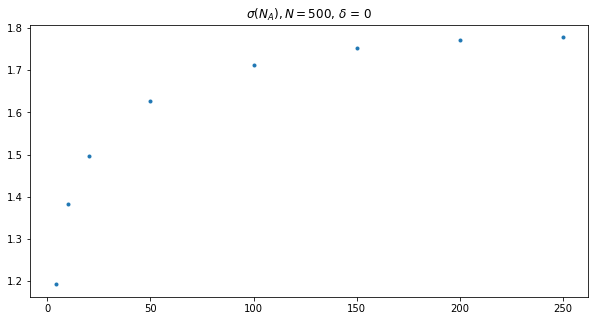

In [131]:
sigma_arrayNA2 = sigma(np.array([coeff_NA02[0], coeff_NA12[0], coeff_NA22[0], coeff_NA32[0], coeff_NA42[0],coeff_NA52[0], 
                                coeff_NA62[0], coeff_NA72[0]]))
N_array = np.array([4, 10, 20, 50, 100, 150,200, 250])
plt.plot(N_array, sigma_arrayNA2, ".")
#plt.xscale('log')
plt.title("$\sigma (N_A), N = 500 $, $\delta$ = 0")